In [201]:
# STEP 1: Install and import required libraries
!pip install skyfield numpy pandas scikit-learn shap matplotlib scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import requests
from io import StringIO
from skyfield.api import EarthSatellite, load, wgs84
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import shap

# Set random seed for reproducibility
np.random.seed(42)

In [202]:
# STEP 2: Download and parse satellite data from Celestrak
def download_satellite_data():
    """Download TLE data from Celestrak for active satellites"""
    url = "https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle"
    response = requests.get(url)

    if response.status_code == 200:
        return response.text
    else:
        raise Exception(f"Failed to download data. Status code: {response.status_code}")

# Download the data
print("Downloading satellite data from Celestrak...")
tle_data = download_satellite_data()
print("Download complete!")

# Parse the TLE data
def parse_tle_data(tle_text):
    """Parse TLE data and extract satellite information"""
    satellites = []
    lines = tle_text.strip().split('\n')

    # Process in groups of 3 lines (name, line1, line2)
    for i in range(0, len(lines), 3):
        if i+2 >= len(lines):
            break

        name = lines[i].strip()
        line1 = lines[i+1].strip()
        line2 = lines[i+2].strip()

        # Create satellite object
        try:
            satellite = EarthSatellite(line1, line2, name)
            satellites.append({
                'name': name,
                'sat_obj': satellite,
                'line1': line1,
                'line2': line2,
                'norad_id': line2[2:7],  # Extract NORAD ID from line2
            })
        except:
            # Skip invalid TLE entries
            continue

    return satellites

print("Parsing TLE data...")
satellites = parse_tle_data(tle_data)
print(f"Successfully parsed {len(satellites)} satellites")

Download complete!
Parsing TLE data...
Successfully parsed 12560 satellites


In [203]:
# STEP 3: Extract orbital parameters and create a DataFrame
def extract_orbital_parameters(satellites):
    """Extract orbital parameters from satellite objects"""
    orbital_data = []
    ts = load.timescale()

    for sat in satellites:
        # Extract parameters from the satellite's model
        model = sat['sat_obj'].model

        orbital_data.append({
            'name': sat['name'],
            'norad_id': sat['norad_id'],
            'inclination_deg': model.inclo * 180/np.pi,  # Convert from radians to degrees
            'eccentricity': model.ecco,
            'mean_motion': model.no,  # Revolutions per day
            'raan_deg': model.nodeo * 180/np.pi,  # Right Ascension of Ascending Node
            'arg_perigee_deg': model.argpo * 180/np.pi,  # Argument of Perigee
            'mean_anomaly_deg': model.mo * 180/np.pi,  # Mean Anomaly
            'bstar': model.bstar,  # Drag coefficient
            'period_min': (24 * 60) / model.no if model.no > 0 else 0,  # Period in minutes
        })

    return pd.DataFrame(orbital_data)

print("Extracting orbital parameters...")
df_satellites = extract_orbital_parameters(satellites)
print("DataFrame created with orbital parameters")
df_satellites.head()

Extracting orbital parameters...
DataFrame created with orbital parameters


,name,norad_id,inclination_deg,eccentricity,mean_motion,raan_deg,arg_perigee_deg,mean_anomaly_deg,bstar,period_min
0,CALSPHERE 1,00900,90.2132,0.002716,0.060047,65.3047,62.3793,1.8244,0.000605,23981.104565
1,CALSPHERE 2,00902,90.2262,0.001737,0.059030,69.1977,325.7368,175.0763,0.000059,24394.315838
2,LCS 1,01361,32.1389,0.001340,0.043167,122.1441,211.4271,148.5425,0.002003,33358.998915
3,TEMPSAT 1,01512,89.9823,0.006836,0.058188,212.7647,317.0963,96.7473,0.000038,24747.361078
4,CALSPHERE 4A,01520,89.9158,0.006933,0.058303,125.0565,172.7927,299.4337,0.000173,24698.408281


In [204]:
# STEP 4: Simulate ALL conjunctions between satellites (with error handling)
def simulate_all_conjunctions(satellite_list, distance_threshold_km=200):
    """
    Simulate ALL conjunctions between satellites (find all pairs closer than threshold)

    Parameters:
    - satellite_list: List of satellite dictionaries
    - distance_threshold_km: Distance threshold for considering a conjunction
    """
    # Create time object for simulation (use a fixed time for consistency)
    ts = load.timescale()
    t = ts.utc(2023, 11, 10, 12, 0, 0)  # Fixed time for consistency

    # Calculate positions for ALL satellites
    positions = []
    velocities = []
    names = []
    norad_ids = []
    sizes = []  # We'll use a proxy for size based on satellite type

    print("Calculating positions for all satellites...")
    for i, sat in enumerate(satellite_list):
        if i % 100 == 0:
            print(f"Processing satellite {i+1}/{len(satellite_list)}")
        try:
            # Calculate position and velocity
            geocentric = sat['sat_obj'].at(t)
            position = geocentric.position.km
            velocity = geocentric.velocity.km_per_s

            # Check for NaN or infinite values
            if np.any(np.isnan(position)) or np.any(np.isinf(position)):
                continue
            if np.any(np.isnan(velocity)) or np.any(np.isinf(velocity)):
                continue

            positions.append(position)
            velocities.append(velocity)
            names.append(sat['name'])
            norad_ids.append(sat['norad_id'])

            # Create a size proxy based on satellite name/type
            name_lower = sat['name'].lower()
            if any(word in name_lower for word in ['debris', 'rocket', 'upper stage']):
                sizes.append(np.random.uniform(5, 15))  # Larger for debris/rocket bodies
            elif 'starlink' in name_lower:
                sizes.append(np.random.uniform(1, 3))   # Smaller for Starlink satellites
            else:
                sizes.append(np.random.uniform(2, 8))   # Medium for other satellites

        except Exception as e:
            # Skip satellites that can't be processed
            continue

    positions = np.array(positions)
    velocities = np.array(velocities)
    sizes = np.array(sizes)

    print(f"Successfully processed {len(positions)} satellites with valid positions")

    # If we have too few satellites, use a simpler approach
    if len(positions) < 2:
        print("Not enough satellites with valid positions for conjunction analysis")
        return []

    print("Finding conjunctions (this may take a while)...")

    try:
        # Calculate pairwise distances more efficiently using KDTree
        from scipy.spatial import KDTree

        # Create a KDTree for efficient distance queries
        tree = KDTree(positions)

        # Find all pairs within the threshold distance
        pairs = tree.query_pairs(distance_threshold_km)

        # Convert to list for easier processing
        pairs = list(pairs)

        print(f"Found {len(pairs)} potential conjunction pairs under {distance_threshold_km} km.")

        # Create conjunction data
        conjunction_pairs = []
        for i, j in pairs:
            # Calculate relative velocity
            rel_velocity = np.linalg.norm(velocities[i] - velocities[j])

            conjunction_pairs.append({
                'sat1_name': names[i],
                'sat2_name': names[j],
                'sat1_norad': norad_ids[i],
                'sat2_norad': norad_ids[j],
                'distance_km': np.linalg.norm(positions[i] - positions[j]),
                'relative_velocity_kms': rel_velocity,
                'sat1_size': sizes[i],
                'sat2_size': sizes[j],
                'combined_size': sizes[i] + sizes[j]
            })

        return conjunction_pairs

    except Exception as e:
        print(f"Error using KDTree: {e}")
        print("Falling back to manual distance calculation...")

        # Manual calculation as fallback
        conjunction_pairs = []
        n = len(positions)

        for i in range(n):
            for j in range(i+1, n):
                distance = np.linalg.norm(positions[i] - positions[j])
                if distance < distance_threshold_km:
                    # Calculate relative velocity
                    rel_velocity = np.linalg.norm(velocities[i] - velocities[j])

                    conjunction_pairs.append({
                        'sat1_name': names[i],
                        'sat2_name': names[j],
                        'sat1_norad': norad_ids[i],
                        'sat2_norad': norad_ids[j],
                        'distance_km': distance,
                        'relative_velocity_kms': rel_velocity,
                        'sat1_size': sizes[i],
                        'sat2_size': sizes[j],
                        'combined_size': sizes[i] + sizes[j]
                    })

        print(f"Found {len(conjunction_pairs)} conjunction pairs with manual calculation")
        return conjunction_pairs

print("Simulating ALL conjunctions...")
conjunctions = simulate_all_conjunctions(satellites, distance_threshold_km=100)
print(f"Found {len(conjunctions)} conjunction events")

Simulating ALL conjunctions...
Calculating positions for all satellites...
Processing satellite 1/12560
Processing satellite 101/12560
Processing satellite 201/12560
Processing satellite 301/12560
Processing satellite 401/12560
Processing satellite 501/12560
Processing satellite 601/12560
Processing satellite 701/12560
Processing satellite 801/12560
Processing satellite 901/12560
Processing satellite 1001/12560
Processing satellite 1101/12560
Processing satellite 1201/12560
Processing satellite 1301/12560
Processing satellite 1401/12560
Processing satellite 1501/12560
Processing satellite 1601/12560
Processing satellite 1701/12560
Processing satellite 1801/12560
Processing satellite 1901/12560
Processing satellite 2001/12560
Processing satellite 2101/12560
Processing satellite 2201/12560
Processing satellite 2301/12560
Processing satellite 2401/12560
Processing satellite 2501/12560
Processing satellite 2601/12560
Processing satellite 2701/12560
Processing satellite 2801/12560
Processin

In [205]:
import pandas as pd
import numpy as np

def create_conjunction_dataframe(conjunctions, n_samples=5000):
    """Create a DataFrame from conjunction data and add synthetic risk labels"""
    # Convert to DataFrame (supports None input and empty array)
    df = pd.DataFrame(conjunctions if conjunctions is not None else [])

    # If no data, create a synthetic dataset
    if df.empty:
        print(f"No conjunctions found, creating {n_samples} synthetic samples for demonstration")
        df = pd.DataFrame({
            'distance_km': np.random.uniform(1, 1000, n_samples),
            'relative_velocity_kms': np.random.uniform(0.1, 15, n_samples),
            'combined_size': np.random.uniform(1, 20, n_samples)
        })

    # Create synthetic risk scores
    risk_scores = (
        (1 / df['distance_km'].replace(0, 1e-6)) * 100 + # Prevent divide by zero
        df['relative_velocity_kms'] * 2 +
        df['combined_size'] * 3
    )

    # Normalize risk scores
    risk_scores_normalized = (risk_scores - risk_scores.min()) / (risk_scores.max() - risk_scores.min())
    df['risk_score'] = risk_scores_normalized

    low_threshold = np.percentile(risk_scores_normalized, 33.33)
    high_threshold = np.percentile(risk_scores_normalized, 66.67)

    df['risk_category'] = pd.cut(
        risk_scores_normalized,
        bins=[-np.inf, low_threshold, high_threshold, np.inf], # Use -inf/+inf for coverage
        labels=['Low', 'Medium', 'High'],
        include_lowest=True
    )

    return df

# Create dataset with 10,000 samples if conjunctions is empty
df_conjunctions = create_conjunction_dataframe(conjunctions, n_samples=10000)
print("Conjunction DataFrame created with", len(df_conjunctions), "samples")
print(df_conjunctions.head())


Conjunction DataFrame created with 2159 samples
        sat1_name       sat2_name sat1_norad sat2_norad  distance_km  \
0   STARLINK-5870  STARLINK-33823      57222      63661    92.582910   
1  STARLINK-32032    KUIPER-00059      60077      64519    98.821466   
2  STARLINK-32473  STARLINK-33859      62049      63640    88.866533   
3   STARLINK-2500           PADRE      48485      64559    61.519148   
4   STARLINK-3130   STARLINK-3889      49437      52331    85.544520   

   relative_velocity_kms  sat1_size  sat2_size  combined_size    risk_score  \
0               4.662518   2.326981   2.638461       4.965442  1.767154e-07   
1               2.436702   1.887199   2.985446       4.872646  1.287333e-07   
2               9.594360   1.921370   2.507008       4.428378  2.596920e-07   
3               5.973128   2.608874   3.516456       6.125330  2.431782e-07   
4               0.093824   1.530652   1.612927       3.143579  3.157438e-08   

  risk_category  
0        Medium  
1       

In [206]:
# STEP 6: Prepare data for machine learning
# Define features and target
X = df_conjunctions[['distance_km', 'relative_velocity_kms', 'combined_size']]
y = df_conjunctions['risk_category']

# Encode target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split (90% train, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.22, random_state=42
)

# Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data prepared for machine learning")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

✅ Data prepared for machine learning
Training set: 1684 samples
Test set: 475 samples


Training and evaluating models...

🔹 Training Logistic Regression...
Accuracy: 0.8968
Classification Report:
              precision    recall  f1-score   support

         Low       0.93      0.95      0.94       149
      Medium       0.87      0.97      0.92       167
        High       0.90      0.77      0.83       159

    accuracy                           0.90       475
   macro avg       0.90      0.90      0.90       475
weighted avg       0.90      0.90      0.89       475


🔹 Training Decision Tree...
Accuracy: 0.9432
Classification Report:
              precision    recall  f1-score   support

         Low       0.95      0.97      0.96       149
      Medium       0.95      0.97      0.96       167
        High       0.93      0.89      0.91       159

    accuracy                           0.94       475
   macro avg       0.94      0.94      0.94       475
weighted avg       0.94      0.94      0.94       475


🔹 Training Random Forest...
Accuracy: 0.9579
Classification

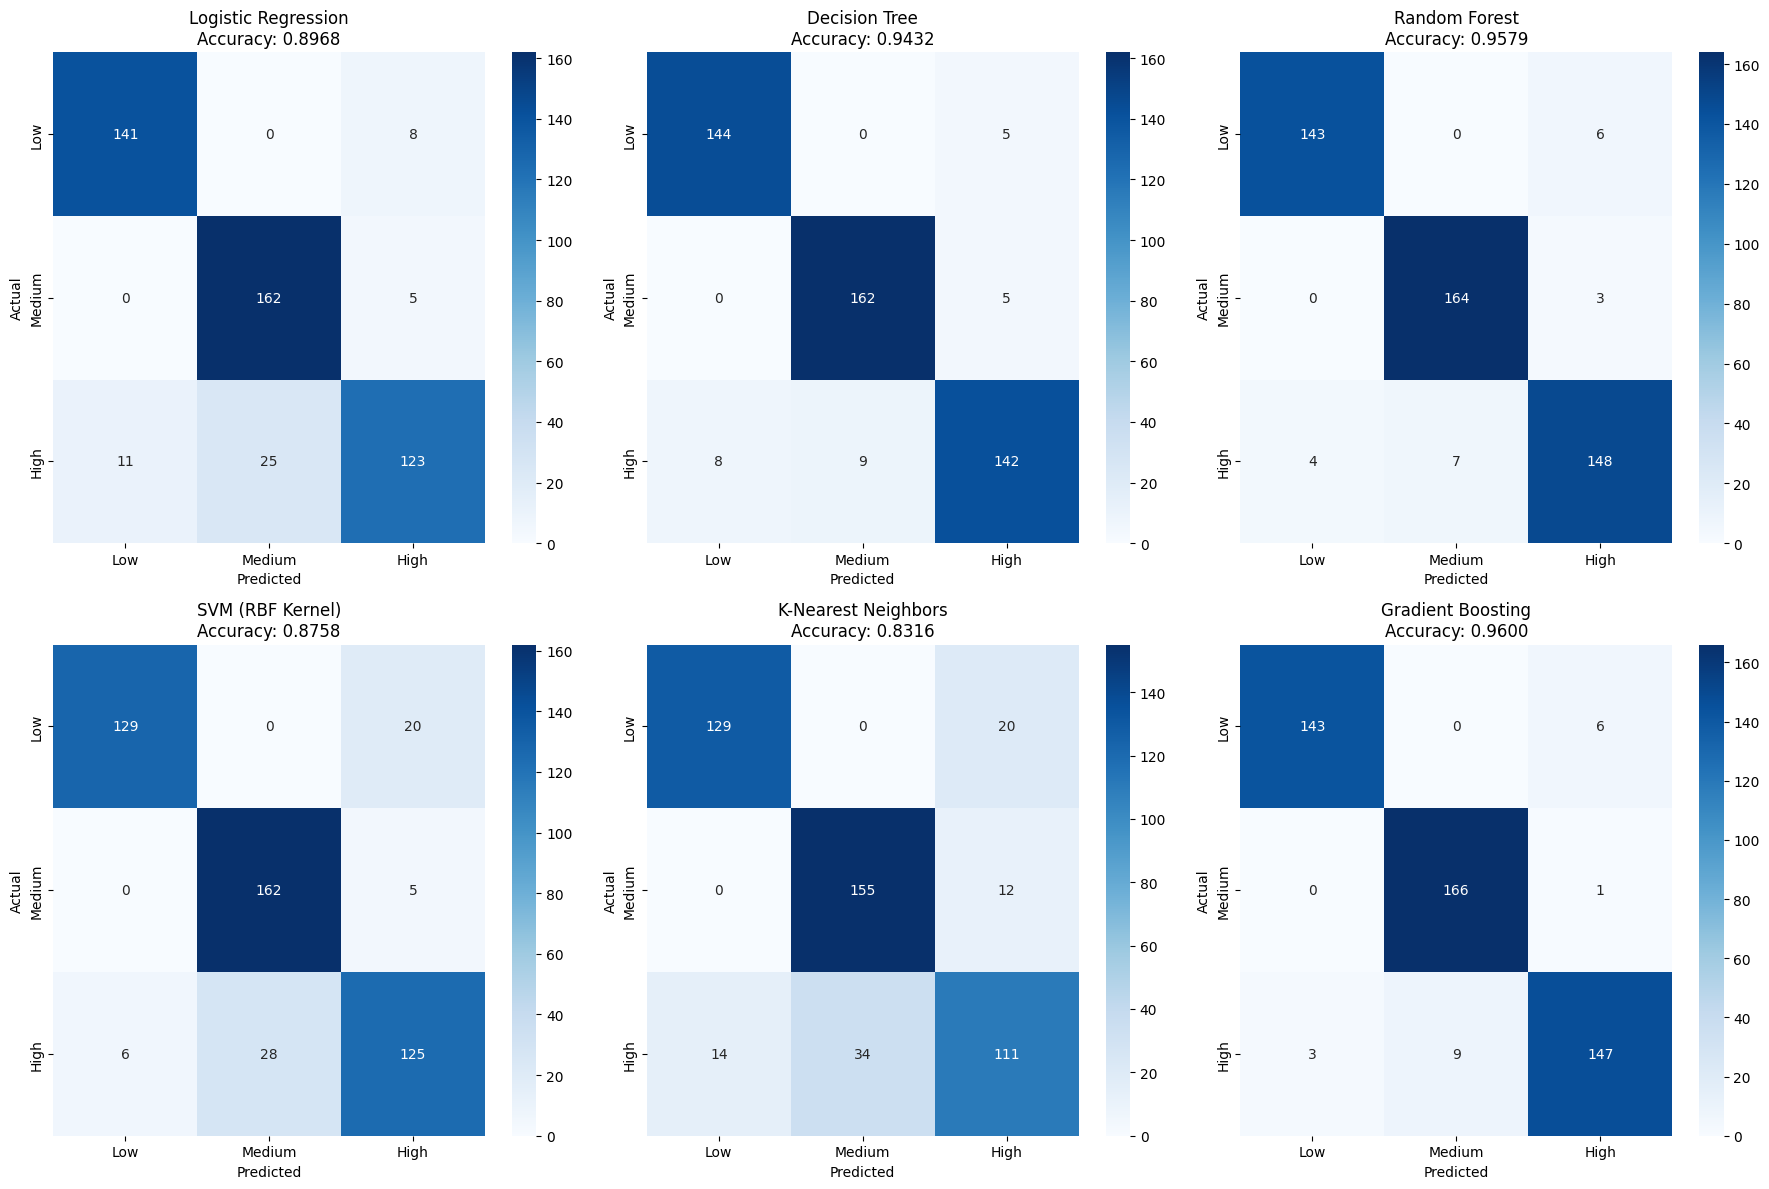

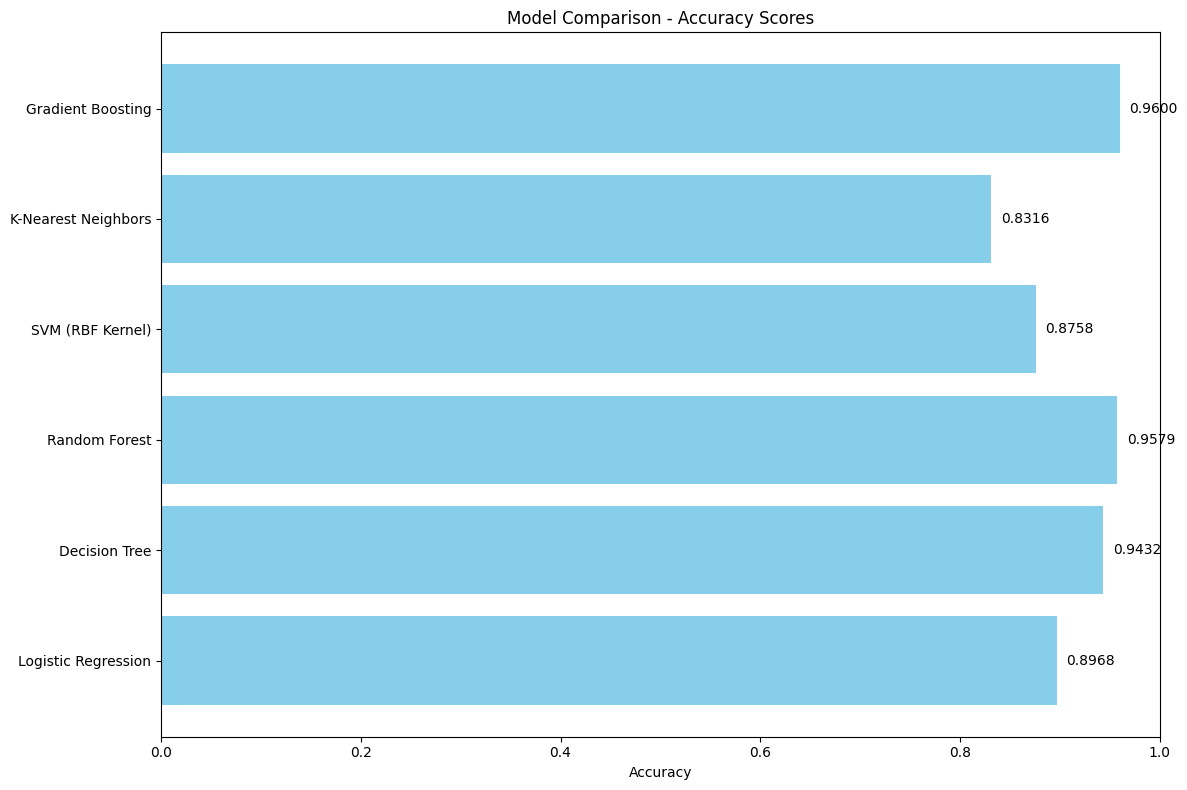


🏆 Best model: Gradient Boosting with accuracy 0.9600


In [207]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (RBF Kernel)": SVC(kernel="rbf", random_state=42, probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}
# Get the class labels and names - FIXED THIS PART
labels = [0, 1, 2]  # Explicitly define numeric labels
target_names = ['Low', 'Medium', 'High']  # Explicitly define string labels

# Create a figure for all confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

print("Training and evaluating models...")

for idx, (name, clf) in enumerate(models.items()):
    print(f"\n🔹 Training {name}...")

    # Train the model
    clf.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = clf.predict(X_test_scaled)

    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred,
                               labels=labels,
                               target_names=target_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=target_names, yticklabels=target_names,
                ax=axes[idx])
    axes[idx].set_title(f"{name}\nAccuracy: {acc:.4f}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Compare model accuracies
plt.figure(figsize=(12, 8))
model_names = list(results.keys())
accuracies = list(results.values())

bars = plt.barh(model_names, accuracies, color='skyblue')
plt.xlabel("Accuracy")
plt.title("Model Comparison - Accuracy Scores")
plt.xlim(0, 1)  # Accuracy ranges from 0 to 1

# Add value labels on bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{accuracy:.4f}', ha='left', va='center')

plt.tight_layout()
plt.show()

# Find the best model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\n🏆 Best model: {best_model_name} with accuracy {results[best_model_name]:.4f}")

In [208]:
# Example for Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

train_acc = rf_model.score(X_train_scaled, y_train)
test_acc = rf_model.score(X_test_scaled, y_test)

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")


Training Accuracy: 1.00
Test Accuracy: 0.96


In [209]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation on the best model (Random Forest)
# Using the scaled training data and encoded training labels
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5) # Using 5 folds

print(f"\nCross-validation scores for Random Forest: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.4f}")
print(f"Standard deviation of cross-validation scores: {cv_scores.std():.4f}")

# Check for overfitting
if train_acc > cv_scores.mean() and (train_acc - cv_scores.mean()) > 0.05: # Check for a significant difference
    print("\nPotential overfitting detected: Training accuracy is significantly higher than the mean cross-validation score.")
else:
    print("\nNo significant overfitting detected based on cross-validation.")


Cross-validation scores for Random Forest: [0.96142433 0.94658754 0.96142433 0.95845697 0.97619048]
Mean cross-validation score: 0.9608
Standard deviation of cross-validation scores: 0.0094

No significant overfitting detected based on cross-validation.


Training the ensemble model...
Ensemble model training complete.

Ensemble Model Accuracy: 0.9579

Ensemble Model Classification Report:
              precision    recall  f1-score   support

         Low       0.98      0.96      0.97       149
      Medium       0.95      0.99      0.97       167
        High       0.95      0.92      0.94       159

    accuracy                           0.96       475
   macro avg       0.96      0.96      0.96       475
weighted avg       0.96      0.96      0.96       475



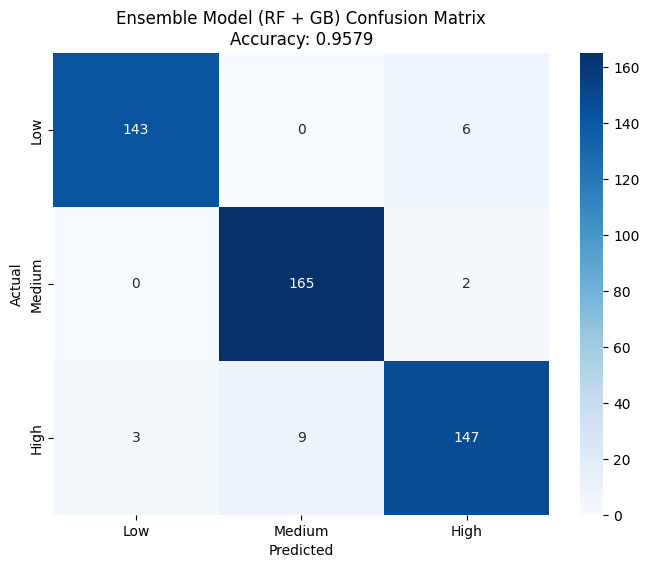


Comparing Ensemble Accuracy with Individual Models:
Random Forest Accuracy: 0.9579
Gradient Boosting Accuracy: 0.9600
Ensemble Model Accuracy: 0.9579


In [210]:
from sklearn.ensemble import VotingClassifier

# Define the individual models
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)

# Create an ensemble model using VotingClassifier
# 'soft' voting uses predicted probabilities
ensemble_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('gb', gb_clf)],
    voting='soft'
)

print("Training the ensemble model...")
# Train the ensemble model on the scaled training data
ensemble_clf.fit(X_train_scaled, y_train)
print("Ensemble model training complete.")

# Make predictions on the scaled test data
y_pred_ensemble = ensemble_clf.predict(X_test_scaled)

# Evaluate the ensemble model
ensemble_acc = accuracy_score(y_test, y_pred_ensemble)
print(f"\nEnsemble Model Accuracy: {ensemble_acc:.4f}")

print("\nEnsemble Model Classification Report:")
print(classification_report(y_test, y_pred_ensemble,
                            labels=labels,
                            target_names=target_names))

# Plot confusion matrix for the ensemble model
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.title(f"Ensemble Model (RF + GB) Confusion Matrix\nAccuracy: {ensemble_acc:.4f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Compare ensemble accuracy with individual models
print("\nComparing Ensemble Accuracy with Individual Models:")
print(f"Random Forest Accuracy: {results['Random Forest']:.4f}")
print(f"Gradient Boosting Accuracy: {results['Gradient Boosting']:.4f}")
print(f"Ensemble Model Accuracy: {ensemble_acc:.4f}")

Training the second ensemble model (Decision Tree + Gradient Boosting + SVM)...
Second ensemble model training complete.

Second Ensemble Model Accuracy: 0.9453

Second Ensemble Model Classification Report:
              precision    recall  f1-score   support

         Low       0.95      0.97      0.96       149
      Medium       0.95      0.98      0.96       167
        High       0.94      0.89      0.92       159

    accuracy                           0.95       475
   macro avg       0.95      0.95      0.94       475
weighted avg       0.95      0.95      0.94       475



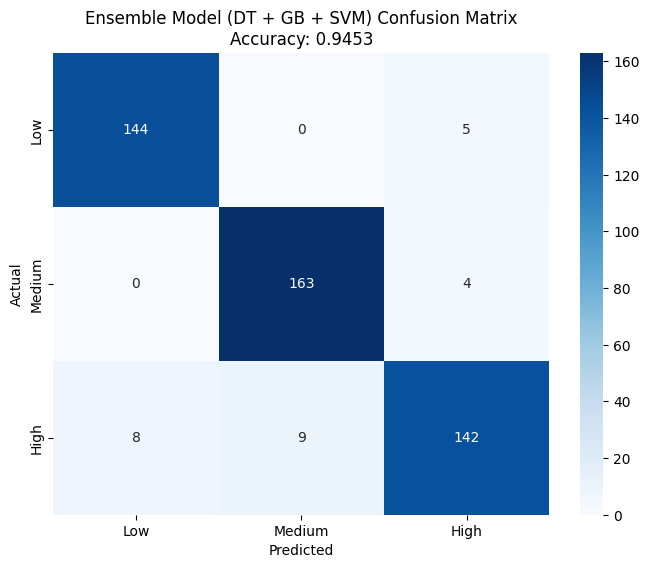


Comparing Ensemble Accuracy with Previous Models:
Random Forest Accuracy: 0.9579
Gradient Boosting Accuracy: 0.9600
SVM (RBF Kernel) Accuracy: 0.8758
Decision Tree Accuracy: 0.9432
Previous Ensemble (RF + GB) Accuracy: 0.9579
Current Ensemble (DT + GB + SVM) Accuracy: 0.9453


In [211]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the individual models
dt_clf = DecisionTreeClassifier(random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)
# Use probability=True for SVC with 'soft' voting
svm_clf = SVC(kernel="rbf", random_state=42, probability=True)

# Create an ensemble model using VotingClassifier
# 'soft' voting uses predicted probabilities from each model
ensemble_clf_2 = VotingClassifier(
    estimators=[('dt', dt_clf), ('gb', gb_clf), ('svm', svm_clf)],
    voting='soft'
)

print("Training the second ensemble model (Decision Tree + Gradient Boosting + SVM)...")
# Train the ensemble model on the scaled training data
ensemble_clf_2.fit(X_train_scaled, y_train)
print("Second ensemble model training complete.")

# Make predictions on the scaled test data
y_pred_ensemble_2 = ensemble_clf_2.predict(X_test_scaled)

# Evaluate the ensemble model
ensemble_acc_2 = accuracy_score(y_test, y_pred_ensemble_2)
print(f"\nSecond Ensemble Model Accuracy: {ensemble_acc_2:.4f}")

print("\nSecond Ensemble Model Classification Report:")
print(classification_report(y_test, y_pred_ensemble_2,
                            labels=labels, # Use the labels defined previously
                            target_names=target_names)) # Use the target_names defined previously

# Plot confusion matrix for the second ensemble model
cm_ensemble_2 = confusion_matrix(y_test, y_pred_ensemble_2, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble_2, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.title(f"Ensemble Model (DT + GB + SVM) Confusion Matrix\nAccuracy: {ensemble_acc_2:.4f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Compare ensemble accuracy with individual models and the previous ensemble
print("\nComparing Ensemble Accuracy with Previous Models:")
print(f"Random Forest Accuracy: {results['Random Forest']:.4f}")
print(f"Gradient Boosting Accuracy: {results['Gradient Boosting']:.4f}")
print(f"SVM (RBF Kernel) Accuracy: {results['SVM (RBF Kernel)']:.4f}")
print(f"Decision Tree Accuracy: {results['Decision Tree']:.4f}")
print(f"Previous Ensemble (RF + GB) Accuracy: {ensemble_acc:.4f}")
print(f"Current Ensemble (DT + GB + SVM) Accuracy: {ensemble_acc_2:.4f}")

In [212]:
!pip install xgboost lightgbm catboost

Training and evaluating new models...

🔹 Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:09:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9558
Classification Report:
              precision    recall  f1-score   support

         Low       0.97      0.99      0.98       149
      Medium       0.94      0.98      0.96       167
        High       0.97      0.90      0.93       159

    accuracy                           0.96       475
   macro avg       0.96      0.96      0.96       475
weighted avg       0.96      0.96      0.96       475


🔹 Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1684, number of used features: 3
[LightGBM] [Info] Start training from score -1.081538
[LightGBM] [Info] Start training from score -1.113569
[LightGBM] [Info] Start training from score -1.100990
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.9705
Classification Report:
              precision    recall  f1-score   support

         Low       0.98      0.99      0.98       149
      Medium       0.96      0.99      0.97       167
        High       0.97      0.94      0.96       159

    accuracy                           0.97       475
   macro avg       0.97      0.97      0.97       475
weighted avg       0.97      0.97      0.97       475


🔹 Training CatBoost...
Accuracy: 0.9747
Classification Report:
              precision    recall  f1-score   support

         Low       0.97      0.99      0.98       149
      Medium       0.98      0.99      0.98       167
        High       0.97      0.95      0.96       159

    accuracy                           0.97       475
   macro avg       0.97      0.97      0.97       475
weighted avg       0.97      0.97      0.97       475



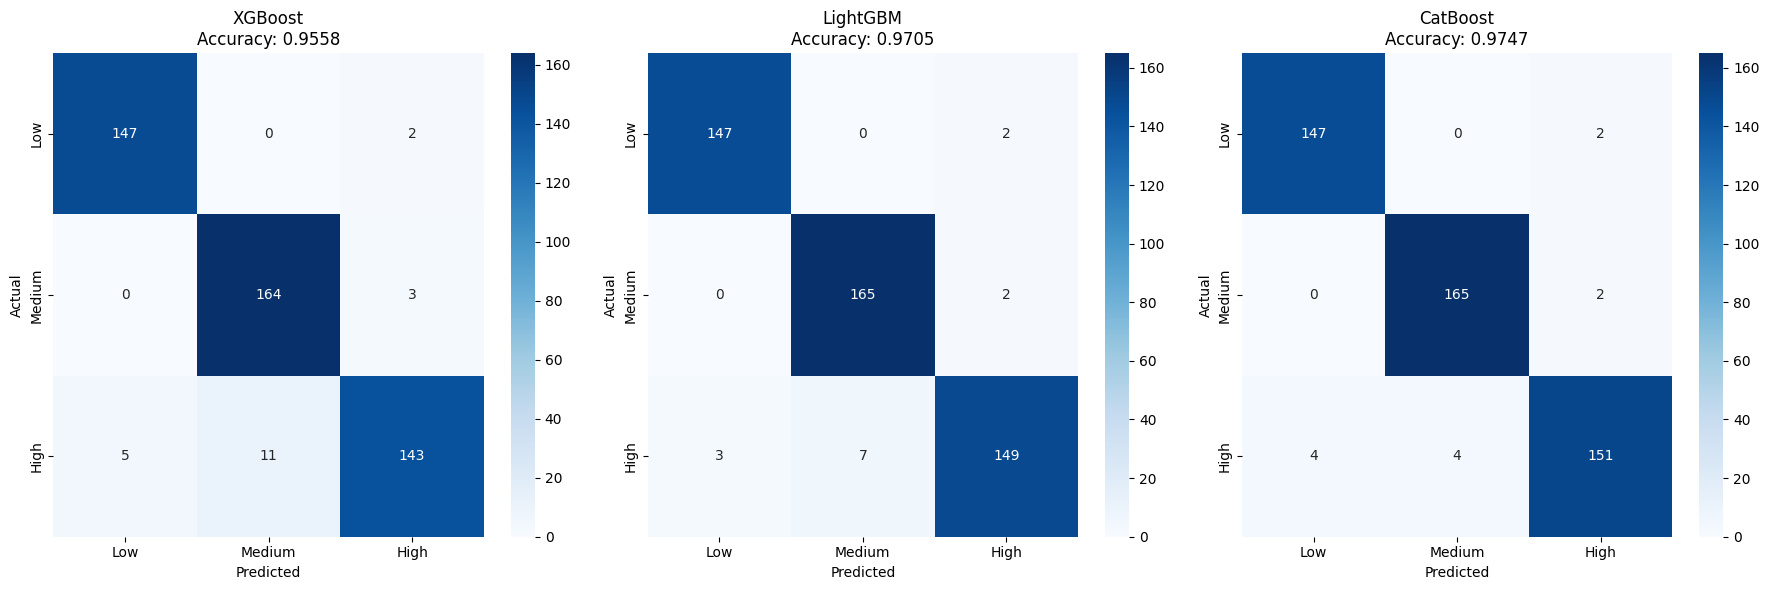

In [213]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Instantiate models
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
lgbm_clf = LGBMClassifier(random_state=42)
catboost_clf = CatBoostClassifier(random_state=42, verbose=0) # verbose=0 to reduce output

models["XGBoost"] = xgb_clf
models["LightGBM"] = lgbm_clf
models["CatBoost"] = catboost_clf

# Get the class labels and names - Use the ones defined previously
labels = [0, 1, 2]
target_names = ['Low', 'Medium', 'High']

# Create a figure for confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.ravel()

print("Training and evaluating new models...")

new_models_to_evaluate = ["XGBoost", "LightGBM", "CatBoost"]

for idx, name in enumerate(new_models_to_evaluate):
    print(f"\n🔹 Training {name}...")
    clf = models[name]

    # Train the model
    clf.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = clf.predict(X_test_scaled)

    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc # Add to the results dictionary

    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred,
                               labels=labels,
                               target_names=target_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=target_names, yticklabels=target_names,
                ax=axes[idx])
    axes[idx].set_title(f"{name}\nAccuracy: {acc:.4f}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

plt.tight_layout()
plt.show()

Model Accuracy Comparison:


,Model,Accuracy
0,CatBoost,0.974737
1,LightGBM,0.970526
2,Gradient Boosting,0.960000
3,Random Forest,0.957895
4,Ensemble (RF + GB),0.957895
5,XGBoost,0.955789
6,Ensemble (DT + GB + SVM),0.945263
7,Decision Tree,0.943158
8,Logistic Regression,0.896842
9,SVM (RBF Kernel),0.875789


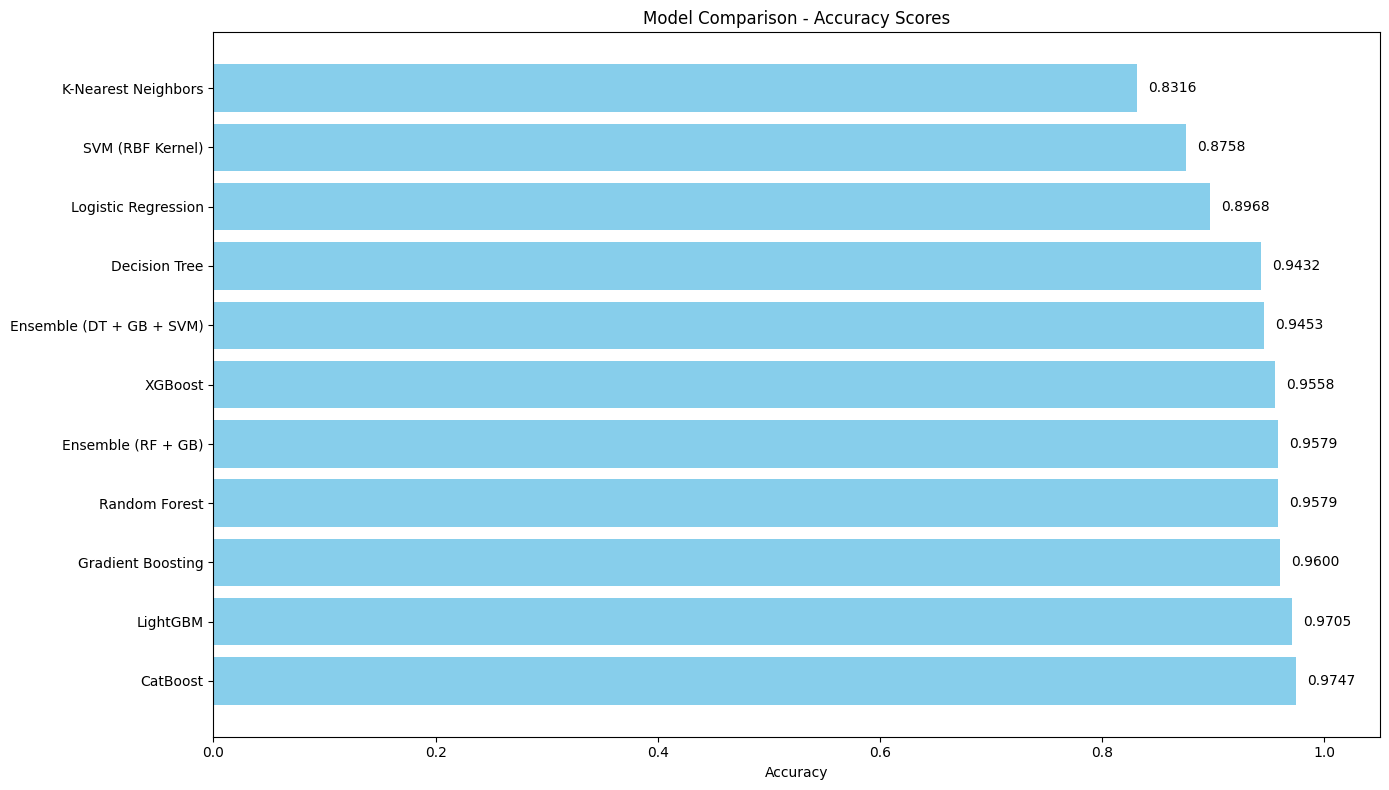


🏆 The best performing model is: CatBoost with accuracy 0.9747


In [214]:
# Add the ensemble accuracies to the results dictionary
results['Ensemble (RF + GB)'] = ensemble_acc
results['Ensemble (DT + GB + SVM)'] = ensemble_acc_2

# Create a DataFrame to display results in a table
df_results = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
df_results = df_results.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("Model Accuracy Comparison:")
display(df_results)

# Create a bar chart to visualize the comparison
plt.figure(figsize=(14, 8))
bars = plt.barh(df_results['Model'], df_results['Accuracy'], color='skyblue')
plt.xlabel("Accuracy")
plt.title("Model Comparison - Accuracy Scores")
plt.xlim(0, 1.05) # Extend x-axis limit slightly for labels

# Add value labels on bars
for bar, accuracy in zip(bars, df_results['Accuracy']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{accuracy:.4f}', ha='left', va='center')

plt.tight_layout()
plt.show()

# Identify the best model
best_model_name = df_results.iloc[0]['Model']
best_model_accuracy = df_results.iloc[0]['Accuracy']

print(f"\n🏆 The best performing model is: {best_model_name} with accuracy {best_model_accuracy:.4f}")

Starting hyperparameter tuning for CatBoost...
Hyperparameter tuning complete.

Best parameters found: {'depth': 4, 'iterations': 200, 'learning_rate': 0.1}
Best cross-validation accuracy: 0.9656

Accuracy of the best tuned CatBoost model on the test set: 0.9684

Comparing Tuned CatBoost Accuracy with Original CatBoost:
Original CatBoost Accuracy: 0.9747
Tuned CatBoost Accuracy: 0.9684

Updated Model Accuracy Comparison (with Tuned CatBoost):


,Model,Accuracy
0,CatBoost,0.974737
1,LightGBM,0.970526
2,CatBoost (Tuned),0.968421
3,Gradient Boosting,0.960000
4,Ensemble (RF + GB),0.957895
5,Random Forest,0.957895
6,XGBoost,0.955789
7,Ensemble (DT + GB + SVM),0.945263
8,Decision Tree,0.943158
9,Logistic Regression,0.896842


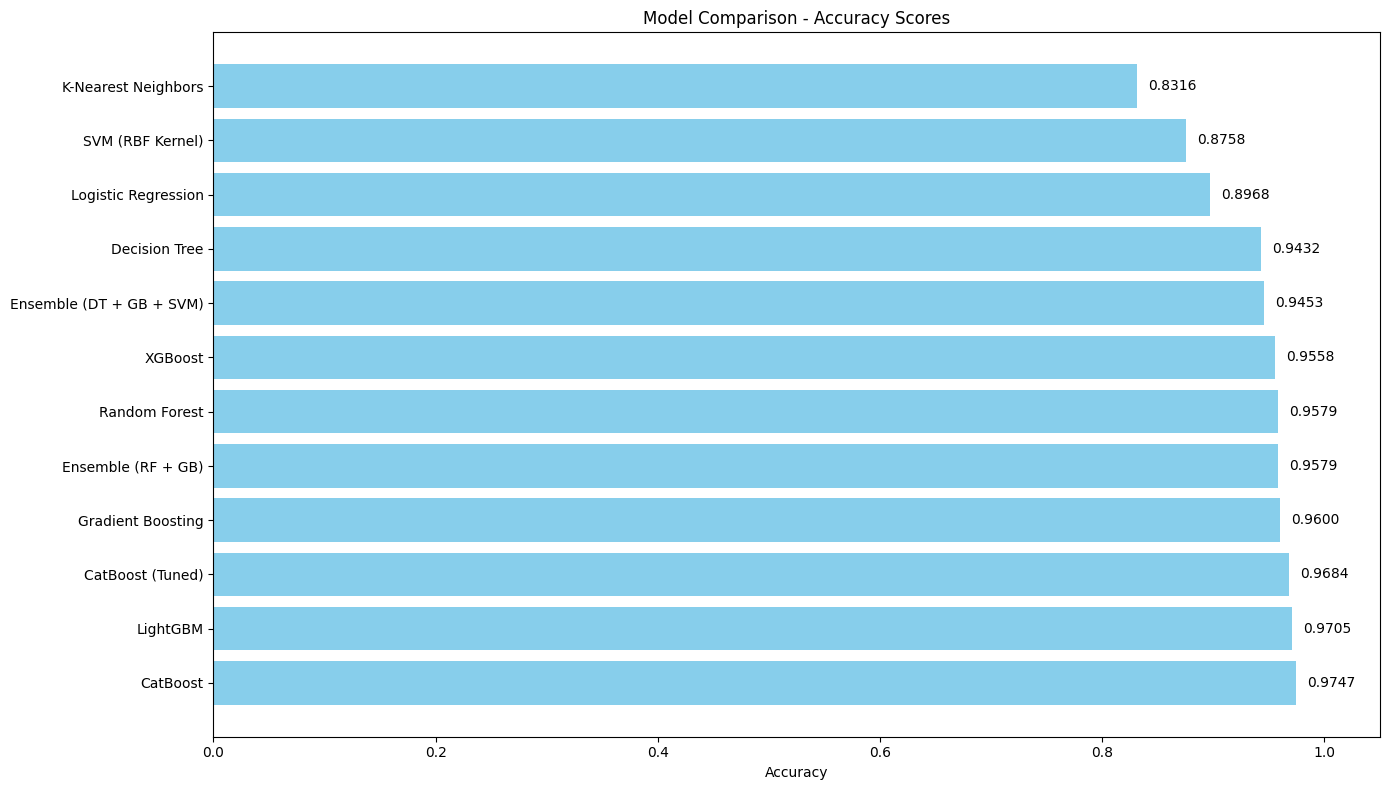


🏆 The best performing model after tuning is: CatBoost with accuracy 0.9747


In [215]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

# Define the CatBoost model
catboost_tuned = CatBoostClassifier(random_state=42, verbose=0)

# Define a smaller parameter grid for demonstration purposes
# For a more thorough tuning, you would include a wider range of parameters
param_grid = {
    'iterations': [100, 200], # Number of boosting iterations
    'learning_rate': [0.05, 0.1], # Step size shrinkage
    'depth': [4, 6] # Depth of the trees
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=catboost_tuned, param_grid=param_grid,
                           cv=3, scoring='accuracy', n_jobs=-1)

print("Starting hyperparameter tuning for CatBoost...")
# Perform grid search on the scaled training data
grid_search.fit(X_train_scaled, y_train)
print("Hyperparameter tuning complete.")

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nBest parameters found: {best_params}")
print(f"Best cross-validation accuracy: {best_score:.4f}")

# Evaluate the best model found by GridSearchCV on the test set
best_catboost_model = grid_search.best_estimator_
y_pred_tuned = best_catboost_model.predict(X_test_scaled)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)

print(f"\nAccuracy of the best tuned CatBoost model on the test set: {tuned_accuracy:.4f}")

# Compare tuned model accuracy with the original CatBoost model
print("\nComparing Tuned CatBoost Accuracy with Original CatBoost:")
print(f"Original CatBoost Accuracy: {results['CatBoost']:.4f}")
print(f"Tuned CatBoost Accuracy: {tuned_accuracy:.4f}")

# Update results dictionary with the tuned model's accuracy
results['CatBoost (Tuned)'] = tuned_accuracy

# Update the results DataFrame and display
df_results = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
df_results = df_results.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("\nUpdated Model Accuracy Comparison (with Tuned CatBoost):")
display(df_results)

# Update the bar chart
plt.figure(figsize=(14, 8))
bars = plt.barh(df_results['Model'], df_results['Accuracy'], color='skyblue')
plt.xlabel("Accuracy")
plt.title("Model Comparison - Accuracy Scores")
plt.xlim(0, 1.05) # Extend x-axis limit slightly for labels

# Add value labels on bars
for bar, accuracy in zip(bars, df_results['Accuracy']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{accuracy:.4f}', ha='left', va='center')

plt.tight_layout()
plt.show()

# Identify the best model after tuning
best_model_name_after_tuning = df_results.iloc[0]['Model']
best_model_accuracy_after_tuning = df_results.iloc[0]['Accuracy']

print(f"\n🏆 The best performing model after tuning is: {best_model_name_after_tuning} with accuracy {best_model_accuracy_after_tuning:.4f}")

In [ ]:
# STEP: Interactive SHAP Analysis for User Queries
print("🔍 Starting Interactive SHAP Analysis...")
print("💡 You can now ask about specific instances and get detailed explanations!")

import shap
import numpy as np
import matplotlib.pyplot as plt

# Use your best model
best_model = catboost_clf
target_names = ['Low', 'Medium', 'High']

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)
X_test_subset = X_test_scaled[:100]  # Use first 100 samples for speed
shap_values = explainer.shap_values(X_test_subset)

print(f"✅ SHAP explainer ready. Test set has {len(X_test)} instances.")
print(f"💡 You can analyze instances 0 to {len(X_test)-1}")

def get_instance_details(instance_idx):
    """Get detailed information about a specific instance"""
    try:
        if instance_idx < 0 or instance_idx >= len(X_test):
            print(f"❌ Instance {instance_idx} is out of range. Please choose 0-{len(X_test)-1}")
            return None

        # Get actual and predicted values
        actual_class_idx = y_test[instance_idx]
        actual_class = target_names[actual_class_idx]

        prediction_proba = best_model.predict_proba(X_test_scaled[instance_idx].reshape(1, -1))[0]
        predicted_class_idx = np.argmax(prediction_proba)
        predicted_class = target_names[predicted_class_idx]
        confidence = prediction_proba[predicted_class_idx]

        # Get feature values
        feature_values = {}
        for feature_name in X.columns:
            if 'X_test' in locals():
                feature_values[feature_name] = X_test.iloc[instance_idx][feature_name]
            else:
                feature_values[feature_name] = X_test_scaled[instance_idx][X.columns.get_loc(feature_name)]

        # Get SHAP values
        instance_shap = shap_values[instance_idx, :, predicted_class_idx]

        return {
            'instance_idx': instance_idx,
            'actual_class': actual_class,
            'predicted_class': predicted_class,
            'confidence': confidence,
            'feature_values': feature_values,
            'shap_values': instance_shap,
            'correct_prediction': (actual_class_idx == predicted_class_idx)
        }

    except Exception as e:
        print(f"❌ Error getting instance details: {e}")
        return None

def explain_instance(instance_details):
    """Generate a comprehensive explanation for an instance"""
    if instance_details is None:
        return

    print(f"\n{'='*80}")
    print(f"🔍 ANALYSIS FOR INSTANCE {instance_details['instance_idx']}")
    print(f"{'='*80}")

    # Basic prediction info
    print(f"📊 Prediction: {instance_details['predicted_class']} risk")
    print(f"   Confidence: {instance_details['confidence']:.3f}")
    if instance_details['correct_prediction']:
        print(f"   ✅ Correct prediction (Actual: {instance_details['actual_class']})")
    else:
        print(f"   ❌ Incorrect prediction (Actual: {instance_details['actual_class']})")

    # Feature values
    print(f"\n📋 Feature Values:")
    for feature_name, value in instance_details['feature_values'].items():
        print(f"   • {feature_name}: {value:.3f}")

    # SHAP explanation
    print(f"\n🎯 Why this is {instance_details['predicted_class']} risk:")

    # Get top contributing features
    contributions = []
    for j, feature_name in enumerate(X.columns):
        shap_val = instance_details['shap_values'][j]
        contributions.append((abs(shap_val), feature_name, shap_val))

    contributions.sort(reverse=True)

    for abs_val, feat_name, shap_val in contributions:
        if abs_val > 0.001:  # Only show significant contributions
            direction = "increases" if shap_val > 0 else "decreases"
            effect = "risk" if shap_val > 0 else "safety"

            # Add context based on feature meaning
            context = ""
            if feat_name == 'distance_km':
                if instance_details['feature_values'][feat_name] < 50:
                    context = " (close distance → high risk)"
                else:
                    context = " (safe distance → low risk)"
            elif feat_name == 'relative_velocity_kms':
                if instance_details['feature_values'][feat_name] > 8:
                    context = " (high velocity → dangerous impact)"
                else:
                    context = " (moderate velocity → manageable risk)"
            elif feat_name == 'combined_size':
                if instance_details['feature_values'][feat_name] > 10:
                    context = " (large objects → greater collision chance)"
                else:
                    context = " (smaller objects → lower impact severity)"

            print(f"   • {feat_name}: {direction} {effect} by {abs_val:.3f}{context}")

    # Risk assessment summary
    print(f"\n⚠️  RISK ASSESSMENT:")
    if instance_details['predicted_class'] == 'High':
        print("   🚨 HIGH RISK: Immediate attention required!")
        print("   Recommended: Evasive maneuver planning, close monitoring")
    elif instance_details['predicted_class'] == 'Medium':
        print("   ⚠️  MEDIUM RISK: Monitor closely")
        print("   Recommended: Regular updates, prepare contingency plans")
    else:
        print("   ✅ LOW RISK: Normal operations")
        print("   Recommended: Routine monitoring")

    print(f"{'='*80}")

def plot_instance_analysis(instance_details):
    """Create visualization for the instance"""
    if instance_details is None:
        return

    # Create force plot for this instance
    plt.figure(figsize=(12, 4))

    # Get the expected value for the predicted class
    expected_value = explainer.expected_value[instance_details['shap_values'].argmax()]

    shap.force_plot(
        expected_value,
        instance_details['shap_values'],
        X_test_scaled[instance_details['instance_idx']],
        feature_names=X.columns,
        matplotlib=True,
        show=False
    )
    plt.title(f'SHAP Force Plot - Instance {instance_details["instance_idx"]} ({instance_details["predicted_class"]} Risk)')
    plt.tight_layout()
    plt.show()

def find_interesting_instances():
    """Find and suggest interesting instances to analyze"""
    print(f"\n🔎 Looking for interesting instances...")

    interesting_instances = []

    # Find high confidence predictions
    all_probas = best_model.predict_proba(X_test_scaled)
    high_confidence_indices = np.where(np.max(all_probas, axis=1) > 0.95)[0][:3]
    interesting_instances.extend(high_confidence_indices)

    # Find incorrect predictions
    predictions = best_model.predict(X_test_scaled)
    incorrect_indices = np.where(y_test != predictions)[0][:2]
    interesting_instances.extend(incorrect_indices)

    # Find high risk predictions
    high_risk_indices = np.where(predictions == target_names.index('High'))[0][:2]
    if len(high_risk_indices) > 0:
        interesting_instances.extend(high_risk_indices)

    # Remove duplicates and limit to 5
    interesting_instances = list(set(interesting_instances))[:5]

    print(f"💡 Suggested instances to analyze: {interesting_instances}")
    print("   - These include high-confidence, incorrect, and high-risk predictions")
    return interesting_instances

# Main interactive loop
def interactive_shap_analysis():
    """Main interactive analysis function"""
    print(f"\n🎯 INTERACTIVE SHAP ANALYSIS")
    print(f"💡 Type 'help' for commands, 'quit' to exit")

    suggested_instances = find_interesting_instances()

    while True:
        print(f"\n{'─'*50}")
        user_input = input("🔍 Enter instance number (or 'help', 'suggest', 'quit'): ").strip().lower()

        if user_input == 'quit' or user_input == 'exit':
            print("👋 Exiting interactive analysis. Goodbye!")
            break

        elif user_input == 'help':
            print(f"\n📋 AVAILABLE COMMANDS:")
            print(f"   [number]    - Analyze specific instance (0-{len(X_test)-1})")
            print(f"   suggest     - Show suggested interesting instances")
            print(f"   stats       - Show dataset statistics")
            print(f"   help        - Show this help message")
            print(f"   quit        - Exit the interactive analysis")

        elif user_input == 'suggest':
            suggested_instances = find_interesting_instances()

        elif user_input == 'stats':
            print(f"\n📊 DATASET STATISTICS:")
            print(f"   Total test instances: {len(X_test)}")
            print(f"   Risk distribution in test set:")
            for i, class_name in enumerate(target_names):
                count = np.sum(y_test == i)
                percentage = count / len(y_test) * 100
                print(f"     {class_name}: {count} instances ({percentage:.1f}%)")

        else:
            # Try to parse as instance number
            try:
                instance_idx = int(user_input)
                details = get_instance_details(instance_idx)

                if details is not None:
                    explain_instance(details)

                    # Ask if user wants to see visualization
                    viz_choice = input("\n📊 Would you like to see the visualization? (y/n): ").strip().lower()
                    if viz_choice in ['y', 'yes']:
                        plot_instance_analysis(details)

                    # Ask if user wants to analyze another instance from the same class
                    same_class_choice = input(f"\n🔍 Analyze another {details['predicted_class']} risk instance? (y/n): ").strip().lower()
                    if same_class_choice in ['y', 'yes']:
                        same_class_indices = np.where(y_test == target_names.index(details['predicted_class']))[0]
                        if len(same_class_indices) > 0:
                            next_idx = same_class_indices[0]  # First instance of same class
                            if next_idx != instance_idx:  # Don't analyze the same instance
                                next_details = get_instance_details(next_idx)
                                if next_details is not None:
                                    explain_instance(next_details)

            except ValueError:
                print("❌ Please enter a valid number or command")
            except Exception as e:
                print(f"❌ Error: {e}")

# Start the interactive analysis
interactive_shap_analysis()

print("\n✅ Interactive SHAP Analysis Complete!")
print("\n🎯 You can now:")
print("   • Ask about any instance by number")
print("   • Get detailed risk explanations")
print("   • See why the model made specific predictions")
print("   • Understand feature contributions to risk assessment")

🔍 Starting Interactive SHAP Analysis...
💡 You can now ask about specific instances and get detailed explanations!
✅ SHAP explainer ready. Test set has 475 instances.
💡 You can analyze instances 0 to 474

🎯 INTERACTIVE SHAP ANALYSIS
💡 Type 'help' for commands, 'quit' to exit

🔎 Looking for interesting instances...
💡 Suggested instances to analyze: [np.int64(0), np.int64(2), np.int64(4)]
   - These include high-confidence, incorrect, and high-risk predictions

──────────────────────────────────────────────────

🔍 ANALYSIS FOR INSTANCE 8
📊 Prediction: High risk
   Confidence: 0.997
   ✅ Correct prediction (Actual: High)

📋 Feature Values:
   • distance_km: 0.966
   • relative_velocity_kms: -0.011
   • combined_size: -0.182

🎯 Why this is High risk:
   • relative_velocity_kms: increases risk by 3.803 (moderate velocity → manageable risk)
   • combined_size: increases risk by 0.814 (smaller objects → lower impact severity)
   • distance_km: increases risk by 0.031 (close distance → high ris